In [1]:
import datasets as ds
import spacy
import polars as pl

/home/kkafara/.cache/virtualenvs/python-3.11-venv-ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds_name = "clarin-knext/fiqa-pl"
res_ds_name = "clarin-knext/fiqa-pl-qrels"

corpus_df = ds.load_dataset(ds_name, "corpus")["corpus"].to_pandas()

In [3]:
corpus_df.head(3)

,_id,title,text
0,3,,"Nie mówię, że nie podoba mi się też pomysł szk..."
1,31,,Tak więc nic nie zapobiega fałszywym ocenom po...
2,56,,Nigdy nie możesz korzystać z FSA dla indywidua...


# Zadanie 2

Take 1 thousand random passages from the FIQA-PL corpus.

In [4]:
sample_size = 1000
corpus_df = corpus_df.sample(n=sample_size)

In [5]:
corpus_df.size

3000

In [6]:
corpus_df = ds.Dataset.from_pandas(corpus_df)

# Zadanie 3

Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence.

In [7]:
# Tokenizer dla j. polskiego
# Lematyzacja jest w pipeline'ie
pl_pipeline = spacy.load('pl_core_news_sm')

In [8]:
texts = corpus_df['text']
tokenized_texts = []
for text in texts:
    doc = pl_pipeline(text)
    tokenized_texts.append(doc)

joined_doc: spacy.tokens.Doc = spacy.tokens.Doc.from_docs(tokenized_texts)
del tokenized_texts

# Zadanie 4

Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [9]:
from collections import Counter
from tqdm import tqdm

def entity_yielder(doc: spacy.tokens.Doc):
    if len(doc) < 2:
        return

    iterator = iter(doc)
    next(iterator)  #skip first token

    detection = False
    token_agg = ""
    
    try:
        while token := next(iterator):
            if token.text[0].isupper():
                detection = True

            while detection:
                token_agg = token_agg + ' ' + token.lemma_
                try:
                    token = next(iterator)
                    if not token.text[0].isupper():
                        break
                except StopIteration:
                    break
            
            if detection:
                yield token_agg[1:]
            
            detection = False
    except StopIteration:
        pass

main_counter = Counter()

for doc in tqdm(joined_doc.sents):
    counter = Counter(entity_yielder(doc))
    main_counter += counter

main_counter.most_common(50)

7181it [00:00, 19203.47it/s]


[('dolar_amerykański', 162),
 ('twój', 100),
 ('ty', 73),
 ('USA', 55),
 ('dolar_amerykański dolar_amerykański', 55),
 ('to', 38),
 ('Ciebie', 31),
 ('nie', 29),
 ('Twój', 28),
 ('Stany Zjednoczone', 21),
 ('jeśli', 19),
 ('ETF', 18),
 ('Apple', 18),
 ('dolar_amerykański dolar_amerykański dolar_amerykański', 17),
 ('w', 17),
 ('Amazon', 16),
 ('IRS', 15),
 ('Indie', 15),
 ('Roth IRA', 15),
 ('IRA', 14),
 ('Google', 13),
 ('słowo', 12),
 ('B', 12),
 ('Hamilton', 12),
 ('czy', 11),
 ('PM', 10),
 ('jak', 10),
 ('a', 10),
 ('Facebook', 9),
 ('być', 9),
 ('K', 9),
 ('Rs', 9),
 ('mieć', 9),
 ('po', 8),
 ('tak', 8),
 ('LLC', 8),
 ('Roth', 8),
 ('CD', 8),
 ('Ameryka', 8),
 ('podsumowanie', 8),
 ('RRSP', 7),
 ('ten', 7),
 ('myśleć', 7),
 ('MBA', 7),
 ('ETF ETF', 7),
 ('HSA', 7),
 ('china', 7),
 ('twój twój', 7),
 ('Twoją', 7),
 ('RMD', 7)]

Wygląda to źle, patrz: "Stany Zjednoczone", spodziewałem się, że skoro biorę `lemma_` z tokenu, to powinna być
forma pojedyncza, ale najwyraźniej nie jest.

Natomiast w przypadku "Wielki Brytania" to już działa :thinking_face:

Nie wiem też dlaczego np. "czy" jest wysoko...

Nie widzę błędu w kodzie, więc na razie idę dalej

# Zadanie 5

Apply the NER from SpaCy to identify the named entities in the same set of documents.


In [10]:
class EntityWrapper:
    def __init__(self, span) -> None:
        self.span = span
        self.agg = self.compute_token_add()

    @property
    def start(self):
        return self.span.start

    @property
    def label(self):
        return self.span.label

        
    def compute_token_add(self):
        agg = ''
        for token in self.span:
            agg = agg + ' ' + token.lemma_
        return agg[1:]

        
    def __eq__(self, other: object) -> bool:
        return self.agg == other.agg

    def __hash__(self) -> int:
        return hash(self.agg)

    def __repr__(self) -> str:
        return self.agg

    def __str__(self) -> str:
        return self.agg
            

def wrapper_from_entity(span) -> EntityWrapper:
    return EntityWrapper(span)

def skip_adapter(iterable):  # must be an iterable, not an generator!
    iterable = iter(iterable)

    try:
        next(iterable) # skip first
    except StopIteration:
        return

    try:
        while span := next(iterable):
            yield span
    except StopIteration:
        pass

main_counter = Counter()
for doc in tqdm(joined_doc.sents):
    ents = list(map(wrapper_from_entity, skip_adapter(doc.ents)))
    main_counter += Counter(ents)

0it [00:00, ?it/s]

7181it [00:21, 339.26it/s]


In [11]:
main_counter.most_common(10)

[(USA, 22),
 (Indie, 14),
 (amerykański, 13),
 (Douglas, 13),
 (Apple, 11),
 (ETF, 10),
 (Roth IRA, 8),
 (Hamilton, 8),
 (2015 rok ., 7),
 (GM, 7)]

# Zadanie 6

Plot the frequency (histogram) of the identified classes.

In [22]:
from collections import defaultdict

data_dict = defaultdict(int)
for wrapper, count in main_counter.items():
    data_dict[wrapper.span.label_] += count

data_df = pl.DataFrame(list(data_dict.items()), schema=['Category', 'Count'])
data_df.head(10)

Category,Count
str,i64
"""persName""",253
"""orgName""",255
"""date""",98
"""placeName""",217
"""geogName""",43


/tmp/ipykernel_5159/3633451267.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=data_df, palette='pastel')


<Axes: xlabel='Category', ylabel='Count'>

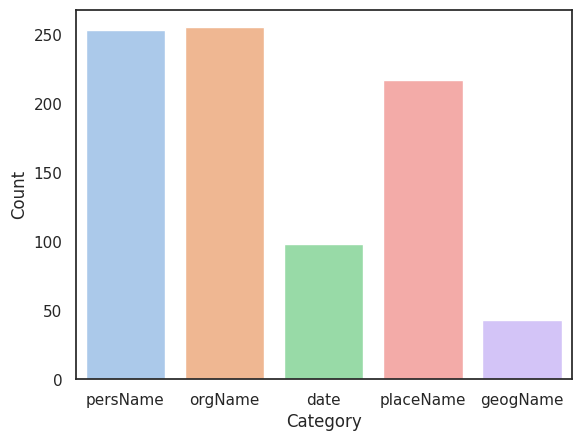

In [23]:
import seaborn as sns

sns.set(style='white')
sns.barplot(x='Category', y='Count', data=data_df, palette='pastel')

# Zadanie 7

Display 10 most frequent Named Entities for each identified type.

In [27]:
entity_type_list = data_df.get_column(name='Category')
entity_list = []
category_list = []
count_list = []
for wrapper, count in main_counter.items():
    entity_list.append(wrapper.agg) 
    category_list.append(wrapper.span.label_)
    count_list.append(count)

df = pl.DataFrame({
    'category': category_list,
    'entity': entity_list,
    'count': count_list
})
df.head(10)

category,entity,count
str,str,i64
"""persName""","""Buffett""",1
"""orgName""","""Wall Streeters…",1
"""persName""","""Ameren""",2
"""date""","""1998 rok""",1
"""orgName""","""Lending Club""",2
"""placeName""","""Holowan Marin""",1
"""persName""","""Rey""",1
"""placeName""","""Kalifornia""",2
"""date""","""2057""",1


In [29]:
pl.Config.set_tbl_rows(20)

for category in entity_type_list:
    data = (df.lazy()
            .filter(pl.col('category') == category)
            .top_k(10, by=(pl.col('count')))
            .collect())
    print(data)

shape: (10, 3)
┌──────────┬───────────┬───────┐
│ category ┆ entity    ┆ count │
│ ---      ┆ ---       ┆ ---   │
│ str      ┆ str       ┆ i64   │
╞══════════╪═══════════╪═══════╡
│ persName ┆ Douglas   ┆ 13    │
│ persName ┆ Hamilton  ┆ 8     │
│ persName ┆ Amazon    ┆ 6     │
│ persName ┆ Facebook  ┆ 5     │
│ persName ┆ Obama     ┆ 4     │
│ persName ┆ Trump     ┆ 4     │
│ persName ┆ walmart   ┆ 3     │
│ persName ┆ Rotha     ┆ 3     │
│ persName ┆ Larry'emu ┆ 3     │
│ persName ┆ Fred      ┆ 3     │
└──────────┴───────────┴───────┘
shape: (10, 3)
┌──────────┬────────────┬───────┐
│ category ┆ entity     ┆ count │
│ ---      ┆ ---        ┆ ---   │
│ str      ┆ str        ┆ i64   │
╞══════════╪════════════╪═══════╡
│ orgName  ┆ Apple      ┆ 11    │
│ orgName  ┆ ETF        ┆ 10    │
│ orgName  ┆ Roth IRA   ┆ 8     │
│ orgName  ┆ GM         ┆ 7     │
│ orgName  ┆ IRA        ┆ 6     │
│ orgName  ┆ SEC        ┆ 4     │
│ orgName  ┆ OPEC       ┆ 4     │
│ orgName  ┆ Google     ┆ 4     │


# Zadanie 8

Display 50 most frequent Named Entities including their count and type.

In [32]:
pl.Config.set_tbl_rows(60)
data = (df.lazy()
        .top_k(50, by=pl.col('count'))
        .collect())
data

category,entity,count
str,str,i64
"""placeName""","""USA""",22
"""placeName""","""Indie""",14
"""placeName""","""amerykański""",13
"""persName""","""Douglas""",13
"""orgName""","""Apple""",11
"""orgName""","""ETF""",10
"""persName""","""Hamilton""",8
"""orgName""","""Roth IRA""",8
"""date""","""2015 rok .""",7


# Zadanie 9

Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color. (For demo application Streamlit might be useful for displaying NER results).


In [33]:
counter = 0
sentences = []
for doc in joined_doc.sents:
    if counter == 5:
        break

    ents = list(skip_adapter(doc.ents))
    if len(ents) < 2:
        continue
    
    counter += 1
    sentences.append(doc)

In [36]:
spacy.displacy.render(sentences, style='ent', jupyter=True)

# WKLEJAM TEŻ SCREENSHOTA POD SPODEM, BO NIE CHCIAŁO WYRENDEROWAĆ SIĘ DO PDFA

![Alt text](image.png)

# Pytania

1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

Nie prowadziłem metryk jakościowych ani ilościowych, moja opinia oparta jest na "wrażeniu". Mimo wszystko wskazuję na przewagę Spacy'ego, choć bardzo nie znaczną.
Nawet jeżeli popatrzymy na te kilka zdań w komórce wyżej, widzimy, że nie jest on w stanie rozpoznać nazw własnych poprawnie / dzieli je na części, np. "Marina Del Rey" <-- metoda z wyszukiwaniem po wielkich literach w tym przypadku akurat poradziła sobie dobrze.


2. What are the drawbacks of the method based on capital letters?

Jest to naiwna metoda. Zakłada ona, że tekst będzie napisany poprawnie, nie bierze ona pod uwagę języka: co będzie z rzeczownikami w niemieckim?! Albo co, gdy ktoś pisał z CapsLockiem? ;D Do tego pomijamy wszystkie nazwy własne,
które występują jednak na pierwszej pozycji w zdaniu.


3. What are the drawbacks of the method based on NER?

Jest ona również daleko od bycia zupełnie poprawną. Widzimy problem z "entity linking", tzn. nie rozpoznawaniem że chodzi o ten sam obiekt, tylko odnosimy się do niego inaczej. Widzimy problem z rodzielanymi nazwami własnymi (koronny przykład z "Marina Del Rey"),
widzimy po prostu błędne kategoryzowanie (w przypadku pierwszej metody w ogóle nie mieliśmy kategorii...) np. Facebook raz jako `orgName`, a raz jako `persName`.


4. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

Patrząc na tabelkę przygotowaną do zadania 8, możemy wysnuć wnioski, że źle to działa szczególnie dla nazw organiacji / miejsc, w tym sensie, że potrafi całkowicie niepasujące rzeczy regularnie kwalifikować do błędnej kategorii (patrz: "amerykański" jako miejsce).
Działa to sensownie do dat.

5. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?

O, jak wspomniałem w odpowiedzi do (3), nie działa to zbyt dobrze. Pierwszym co przychodzi do głowy jest trenowanie modelu przeznaczonego do tego celu / posiadanie ogromnej bazy wiedzy w której moglibyśmy podglądać czy chodzi o to samo, a w przypadkach których nie znamy interpolować modelem.

6. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

Myślę, że dało by się to wykorzystać np. do filtrowania / grupowania dokumentów na podstawie treści których dotyczą, albo np. grupowania zgłoszeń klientów (reklamacji) na podstawie konkretnego opisu usterek (gdyby tego używać do wykrywania innych kategorii niż `name`, `date`, etc.)
